In [1]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset
import torchvision
from PIL import Image
import matplotlib.pyplot as plt
import shutil

In [ ]:
!unzip /content/"Brain Tumor CT scan Images.zip" -d /content/unzipped_data


Visulaisation of the datset

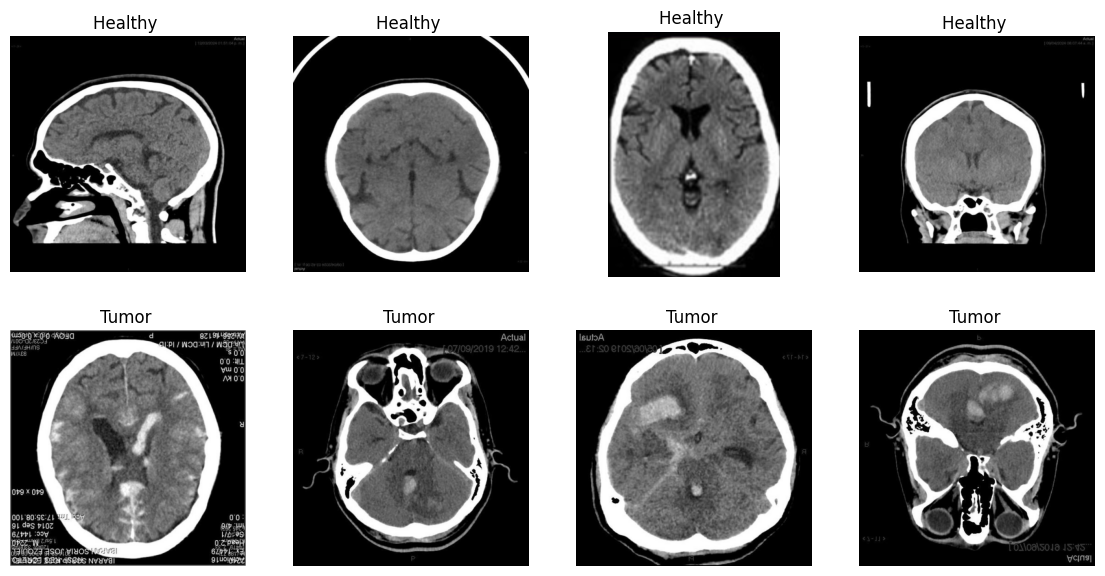

In [3]:
healthy_filenames = os.listdir("/content/dataset/Healthy")
tumor_filenames = os.listdir("/content/dataset/Tumor")


fig,ax = plt.subplots(2,4,figsize=(14,7))

axes = ax.flatten()
for i in range(8):
    healthy_filepath = os.path.join("/content/dataset/Healthy",healthy_filenames[i])
    tumor_filthpath = os.path.join("/content/dataset/Tumor",tumor_filenames[i])
    healthy_img = Image.open(healthy_filepath)
    tumor_img = Image.open(tumor_filthpath)
    if i < 4:
        axes[i].imshow(healthy_img, cmap="Greys")
        axes[i].set_title(f"Healthy ")
        axes[i].axis('off')

    else:
        axes[i] .imshow(tumor_img, cmap="Greys")
        axes[i].set_title(f"Tumor ")
        axes[i].axis('off')






In [4]:
print(f"tumor samples :{len(tumor_filenames)}")
print(f"healthy samples :{len(healthy_filenames)}")

tumor samples :192
healthy samples :2300


tumor samples augmentation 

In [5]:
t = torchvision.transforms.Compose([
    torchvision.transforms.PILToTensor(),
    torchvision.transforms.ConvertImageDtype(torch.float),
    torchvision.transforms.RandomErasing(p=0.3, scale=(0.02, 0.03), ratio=(0.3, 3.3)),
    torchvision.transforms.RandomRotation(degrees=45),
    torchvision.transforms.RandomHorizontalFlip(p=0.5),
    torchvision.transforms.RandomVerticalFlip(p=0.5)

])
t_filenames = os.listdir("/content/dataset/Tumor")
for i in range(len(t_filenames)):
  img = Image.open(os.path.join("/content/dataset/Tumor",t_filenames[i]))
  img = t(img)
  torchvision.utils.save_image(img,f"/content/dataset/Tumor/tumor_augmentes{i}.jpg")


In [6]:
t_f = os.listdir("/content/dataset/Tumor")
h_f = os.listdir("/content/dataset/Healthy")
print(f"tumor samples :{len(t_f)}")
print(f"healthy samples :{len(healthy_filenames)}")


tumor samples :384
healthy samples :2300


In [9]:
from torch.utils.data import random_split, DataLoader
transformer = torchvision.transforms.Compose(
    [torchvision.transforms.PILToTensor(),
    torchvision.transforms.ConvertImageDtype(torch.float),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225]),
    torchvision.transforms.Resize((64,64)),
    torchvision.transforms.RandomHorizontalFlip(0.5)]
)


# loading Dataset
dataset = torchvision.datasets.ImageFolder("/content/dataset",transformer)
#Data split
train_size = int(0.70 * len(dataset))
test_size = int(0.15 * len(dataset))
valid_size =  len(dataset) - train_size - test_size
train_dataset,test_dataset,valid_dataset = random_split(dataset,[train_size,test_size,valid_size])


print((f"{len(train_dataset)} training samples"))
print(f"{len(test_dataset)} test samples")
print(f"{len(valid_dataset)} validation samples")





1878 training samples
402 test samples
404 validation samples


In [10]:
#loaders
train_loader = DataLoader(train_dataset ,batch_size = 16,shuffle = True)
test_loader = DataLoader(test_dataset,batch_size=16,shuffle=False)
valid_loader = DataLoader(valid_dataset,batch_size=1,shuffle=False)
for idx, (x,y) in enumerate(train_loader):
    print(x.size())
    print(y.size())
    break

torch.Size([16, 3, 64, 64])
torch.Size([16])


In [11]:
#model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import torch.nn as nn
class MyCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels = 3 ,out_channels = 256 , kernel_size = 3,stride=1,padding = "same"),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3,stride=2,),
            nn.Conv2d(in_channels = 256,out_channels= 128,kernel_size=3,padding="same"),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3,stride=2),
            nn.Conv2d(in_channels = 128,out_channels= 64,kernel_size = 3,padding ="same"),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3,stride=2),
        )

        self.avg = nn.AdaptiveAvgPool2d((6,6))
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.25),
            nn.Linear(64 *6*6,1024),
            nn.ReLU(),
            nn.Linear(1024,1024),
            nn.ReLU(),
            nn.Linear(1024,2)
        )


    def forward(self,x):
        x= self.layers(x)
        x= self.avg(x)
        x=torch.flatten(x,1)
        x=self.classifier(x)
        return x




In [39]:
#training and validation loop
from tqdm import tqdm
import  torch.optim as optim
torch.manual_seed(123)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model = MyCNN()
model = model.to(device)
loss_fn = nn.CrossEntropyLoss(weight=torch.Tensor([0.4,0.5]).to(device))
optimizer = optim.Adam(model.parameters())
num_epochs = 10
train_loss = []
test_loss = []



for i in tqdm(range(num_epochs)):
    model.train()
    epoch_loss = 0
    num_batches = len(train_loader)
    for i ,(x,y) in enumerate(train_loader):
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        y_hat = model(x)
        loss = loss_fn(y_hat,y)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
    train_loss.append(epoch_loss/num_batches)
    print(f"training loss ={epoch_loss/num_batches:.5f}")

    for i ,(x,y) in enumerate(test_loader):
      model.eval()
      epoch_loss = 0
      num_batches = len(test_loader)
      with torch.no_grad():
        x = x.to(device)
        y = y.to(device)
        y_hat = model(x)
        loss = loss_fn(y_hat,y)
        epoch_loss +=loss.item()
    test_loss.append(epoch_loss/num_batches)
    print(f"test loss: {epoch_loss/num_batches:.5f}")





cuda


  0%|          | 0/10 [00:00<?, ?it/s]

training loss =0.44169


 10%|█         | 1/10 [00:27<04:11, 28.00s/it]

test loss: 0.00516
training loss =0.33224


 20%|██        | 2/10 [00:54<03:37, 27.22s/it]

test loss: 0.00164
training loss =0.27123


 30%|███       | 3/10 [01:21<03:09, 27.05s/it]

test loss: 0.00020
training loss =0.24076


 40%|████      | 4/10 [01:48<02:43, 27.20s/it]

test loss: 0.00326
training loss =0.21129


 50%|█████     | 5/10 [02:15<02:15, 27.04s/it]

test loss: 0.00020
training loss =0.19126


 60%|██████    | 6/10 [02:42<01:48, 27.04s/it]

test loss: 0.00003
training loss =0.20189


 70%|███████   | 7/10 [03:09<01:21, 27.10s/it]

test loss: 0.00001
training loss =0.18891


 80%|████████  | 8/10 [03:37<00:54, 27.25s/it]

test loss: 0.00001
training loss =0.16820


 90%|█████████ | 9/10 [04:04<00:27, 27.12s/it]

test loss: 0.00016
training loss =0.15851


100%|██████████| 10/10 [04:31<00:00, 27.12s/it]

test loss: 0.00060


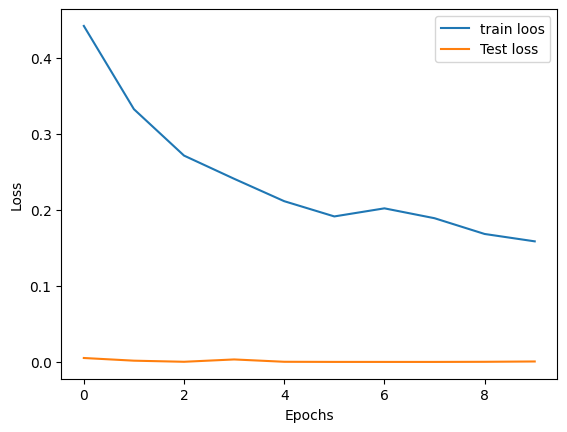

In [40]:
plt.plot(train_loss,label="train loos")
plt.plot(test_loss,label="Test loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

Validiation and confusion matrix

In [41]:
#validation
import torch.nn.functional as F
y_true =[]
y_pred = []
for i ,(x,y) in enumerate(valid_loader):

      y_true.append(torch.Tensor.numpy(y))
      model.eval()
      epoch_loss = 0
      num_batches = len(valid_loader)
      with torch.no_grad():
        x = x.to(device)
        y = y.to(device)
        y_hat = model(x)
        y_probs  = F.softmax(y_hat,dim=1)
        y_hat = torch.argmax(y_hat)
        y_hat = torch.Tensor.cpu(y_hat)
        y_pred.append(torch.Tensor.numpy(y_hat))
        loss = loss_fn(y_probs,y)
        epoch_loss +=loss.item()
print(f"validation loss: {epoch_loss/num_batches:.5f}")




validation loss: 0.00086


accuracy :0.9306930693069307
precision score :0.6857142857142857


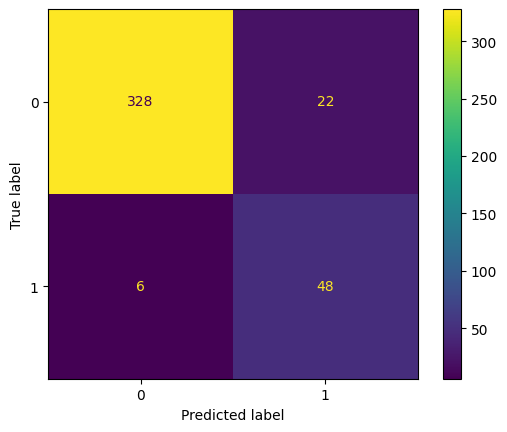

In [42]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
y_pred = np.array(y_pred)
y_true = np.array(y_true)
y_pred.shape
y_pred = np.reshape(y_pred,(404,))
y_true = np.reshape(y_true,(404,))

cm = confusion_matrix(y_true,y_pred)
pr = precision_score(y_true,y_pred)
acc = accuracy_score(y_true,y_pred)

ConfusionMatrixDisplay(cm).plot()
print(f"accuracy :{acc}")
print(f"precision score :{pr}")






In [43]:
torch.save(model,"/content/Model_3.pth")
torch.save(model.state_dict(),"/content/Model_weights_3.pth")


In [44]:
from google.colab import files
files.download("/content/Model_weights_3.pth")
files.download("/content/Model_3.pth")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>